We have decided to present TL by classifying images of horses and humans, we import this dataset from *tensorflow_datasets*.
We will create the base model from a model of **MobileNet V2**.
This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`, but this base of knowledge should help us tell apart `horses` and `humans` from our specific dataset.

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, losses
import tensorflow_hub as hub


# Data preprocessing


## Data download

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# tfds works in both Eager and Graph modes
tf.compat.v1.enable_eager_execution()

# See available datasets
print(tfds.list_builders())
#horses_or_humans

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco2014', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'gigaword', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imagenet_resized', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lfw', 'lm1b', 'lsun', 'malaria', 'mnist'

We need to split the dataset into train, test and validation subsets.

In [4]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'horses_or_humans', split=list(splits),
    with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/1.0.0. Subsequent calls will reuse this data.


Lets have a look at the first images :

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


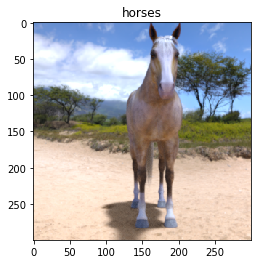

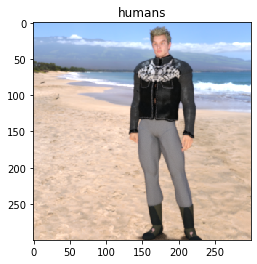

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## Data formating
We need to resize every image so that they all have the same format.
We will use the `tf.image` module.

In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3) #IMG_SIZE=160 

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

We check that our images are at the right format :

In [8]:
print(train)
print(validation)
print(test)


<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


Just to be sure about avoiding overfitting and other potential problems, we can shuffle the data and divide it into batches :
Our batches will be of `size 64`.


In [0]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Here is a batch of data

In [10]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([64, 160, 160, 3])

# Creating our transfer model
We will create the base model from the pre-trained **MobileNet V2** model.
This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

We need to import a pre-trained model.
First, we instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet.

We use tensorflow's hub to find a base model that would be useful for us.
We chose `imagenet/mobilenet_v2_035_160/feature_vector`, which is a model that allows us to extract the features of our dataset useful for later classification, and has as input images of size `160x160` (=IMG_SIZE we converted our images to).

The plan is to use the convolutional base model without the classification layers in order to extract the features of our dataset and then run a classification model on these features. 

## Feature extraction

### Importing the base layer



In [0]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_035_160/feature_vector/4", input_shape=IMG_SHAPE,trainable=False, name='base_Layer') #We need to freeze the weights of this "layer" (ie : of the base model) because we don't want to retrain this model

hub_layer.build([64, 160, 160, 3])
hub_layer.trainable = False

### Creating our classification model

In [0]:


class TransferModelWithHub(tf.keras.Model):

    def __init__(self, hub_layer, hidden_size, output_size):
        super().__init__()
        self.base_layer = hub_layer
        self.dense = tf.keras.layers.Dense(hidden_size, name = 'dense_layer') #Convert the feature vector into a single prediction per image
        self.classifier = tf.keras.layers.Dense(output_size,activation='sigmoid', name='classifier')

    def call(self, x):
        #Estimating the model
        x = self.base_layer(x)
        x = self.dense(x)
        x = self.classifier(x)
        return x

## Training the model

In [13]:
# Net params
output_size = 1 #Binary classification
hidden_size = 32


# Training params
batch_size = 64  #We've already defined this previously but we rewrite here 
                  #When splitting the dataset into batches, we defined the size of each batch
epochs = 3

# Model parameters
optimizer = optimizers.RMSprop(learning_rate=1e-3)
loss = losses.BinaryCrossentropy()
metrics = ['accuracy']

# Training


model = TransferModelWithHub(hub_layer, hidden_size, output_size)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)


loss0,accuracy0 = model.evaluate(validation_batches)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


2/2 [==============================] - 5s 3s/step - loss: 0.7477 - accuracy: 0.5100
initial loss: 0.75
initial accuracy: 0.51


Here is an architecture of the model we just built :

Model: "transfer_model_with_hub"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_Layer (KerasLayer)      multiple                  410208    
_________________________________________________________________
dense_layer (Dense)          multiple                  40992     
_________________________________________________________________
classifier (Dense)           multiple                  33        
Total params: 451,233
Trainable params: 41,025
Non-trainable params: 410,208
_________________________________________________________________


Using TensorFlow backend.


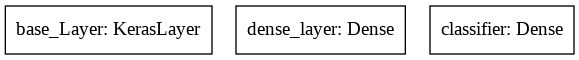

In [14]:
model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_layer_names=True)

In [15]:
history = model.fit(train_batches,
                    epochs=epochs,
                    validation_data=validation_batches)

Epoch 1/3
13/13 [==============================] - 10s 792ms/step - loss: 0.3319 - accuracy: 0.8609 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/3
13/13 [==============================] - 5s 416ms/step - loss: 0.0899 - accuracy: 0.9831 - val_loss: 0.0535 - val_accuracy: 1.0000
Epoch 3/3
13/13 [==============================] - 5s 413ms/step - loss: 0.0516 - accuracy: 0.9903 - val_loss: 0.0241 - val_accuracy: 1.0000


In [22]:
loss_last,accuracy_last = model.evaluate(test_batches)
print("end loss: {:.2f}".format(loss_last))
print("end accuracy: {:.2f}".format(accuracy_last))


2/2 [==============================] - 1s 406ms/step - loss: 0.0478 - accuracy: 0.9900
end loss: 0.05
end accuracy: 0.99


## plotting the results

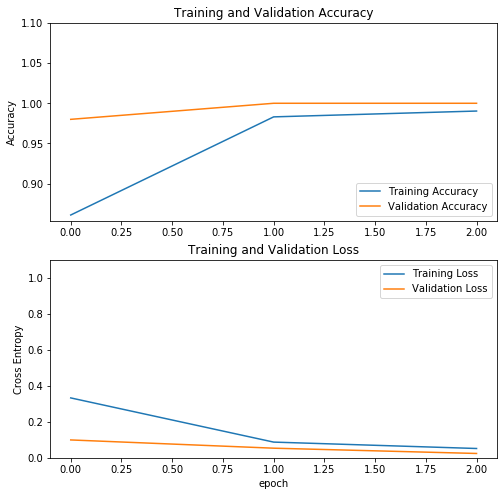

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()